# import library

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

# Load Dataset

In [2]:
IMAGE_SIZE = 264
IMAGE_SIZE = 264
BATCH_SIZE = 32
Channels = 3
epochs = 30

In [3]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    "Blood cell Cancer [ALL]",
    shuffle = True,
    image_size =(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE

)

Found 3242 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['Benign', '[Malignant] Pre-B', '[Malignant] Pro-B', '[Malignant] early Pre-B']

In [5]:
len(dataset)

102

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(264, 264, 3)


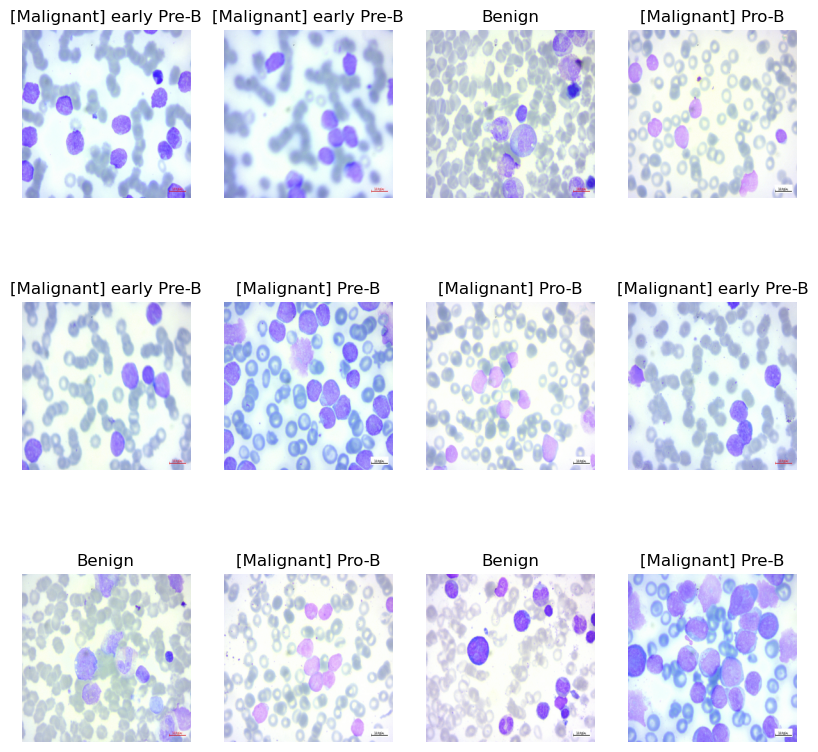

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
                 ax=plt.subplot(3,4,i+1)     
    
                 plt.imshow(image_batch[i].numpy().astype("uint8"))
                 plt.title(class_names[label_batch[i]])
                 plt.axis("off")
                  

# Splitting Dataset

In [8]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
      ds=ds.shuffle(shuffle_size,seed=12)
      train_size = int(train_split*ds_size)
      val_size = int(val_split*ds_size)

      train_ds= ds.take(train_size)
      val_ds = ds.skip(train_size).take(val_size)
      test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds,test_ds

In [9]:
train_ds, val_ds,test_ds =get_dataset_partitions_tf(dataset)

# Data pre process

In [10]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    ])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
    ])

# Soft Attention

In [13]:
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()

In [30]:
MainInput=Input(shape=(264, 264, 3))

In [31]:
conv=(Conv2D(filters=64,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(MainInput))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=64,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))

In [32]:
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))

In [33]:
conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=128,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))

In [34]:
conv=(MaxPooling2D()(conv))

In [35]:
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))

In [36]:
conv=(MaxPooling2D()(conv))

In [37]:
conv=(Conv2D(filters=512,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=512,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=512,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))

# Soft Attention Layer

In [38]:
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv=Activation("relu")(conv)
conv= Dropout(0.5)(conv)

In [39]:
conv=(Conv2D(filters=512,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=512,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=512,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))

In [40]:
conv=(MaxPooling2D(pool_size=(4, 4),padding="same")(conv))

In [41]:
conv=(Flatten()(conv))
conv=(Dense(4096,activation="relu")(conv))
conv=(Dense(4096,activation="relu")(conv))
conv=(Dense(4, activation="softmax")(conv))

model = Model(inputs=MainInput, outputs=conv)

In [42]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 264, 264, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 264, 264, 64  2368        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_13 (BatchN  (None, 264, 264, 64  256        ['conv2d_13[0][0]']              
 ormalization)                  )                                                           

In [43]:
opt1 = tf.keras.optimizers.Adam(learning_rate=0.01, epsilon=0.1)
model.compile(optimizer=opt1,
              loss='categorical_crossentropy',  # Change the loss function
              metrics=['accuracy'])

In [44]:
class_weights = {
    0: 1.0,  # Benign
    1: 1.0,  # [Malignant] Pre-B
    2: 1.0,  # [Malignant] Pro-B
    3: 1.0,  # [Malignant] early Pre-B
}

checkpoint = ModelCheckpoint(filepath='vgg16+SA.hdf5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

In [45]:

Earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=65, min_delta=0.001)

# Modify your training data and batch size
# Assuming you have train_batches and test_batches ready for your 4-class dataset
history = model.fit(train_ds,
                    epochs=10,
                    verbose=2,
                    validation_data=val_ds,
                    callbacks=[checkpoint, Earlystop],
                    class_weight=class_weights)
                    


Epoch 1/10


ValueError: in user code:

    File "d:\Software Study\Anaconda\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "d:\Software Study\Anaconda\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Software Study\Anaconda\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "d:\Software Study\Anaconda\lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "d:\Software Study\Anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "d:\Software Study\Anaconda\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 264, 264, 4), found shape=(None, 264, 264, 3)


In [ ]:
from tensorflow.keras import models
model.load_weights("vgg16+SA.hdf5")